In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

In [2]:
import FinanceDataReader as fdr

In [3]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2023-07-01', '2024-12-31')
df.tail

<bound method NDFrame.tail of              Open   High    Low  Close    Volume    Change
Date                                                      
2023-07-03  72700  73200  72600  73000  10722181  0.011080
2023-07-04  73400  73600  72900  73000  10214350  0.000000
2023-07-05  73000  73300  71900  72000  12310610 -0.013699
2023-07-06  71900  72400  71500  71600  14777667 -0.005556
2023-07-07  71100  71400  69800  69900  17308877 -0.023743
...           ...    ...    ...    ...       ...       ...
2024-01-18  71600  72000  70700  71700  17853397  0.009859
2024-01-19  73500  74700  73000  74700  23363427  0.041841
2024-01-22  75900  76000  75000  75100  19673375  0.005355
2024-01-23  75700  75800  74300  75200  14786224  0.001332
2024-01-24  75200  75200  73500  73600   7739773 -0.021277

[139 rows x 6 columns]>

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn # Neural Network
import torch.optim as optim # 최적화
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# GPU 꼭 연결해서 사용하세요~! -> T4 GPU에 연결함
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

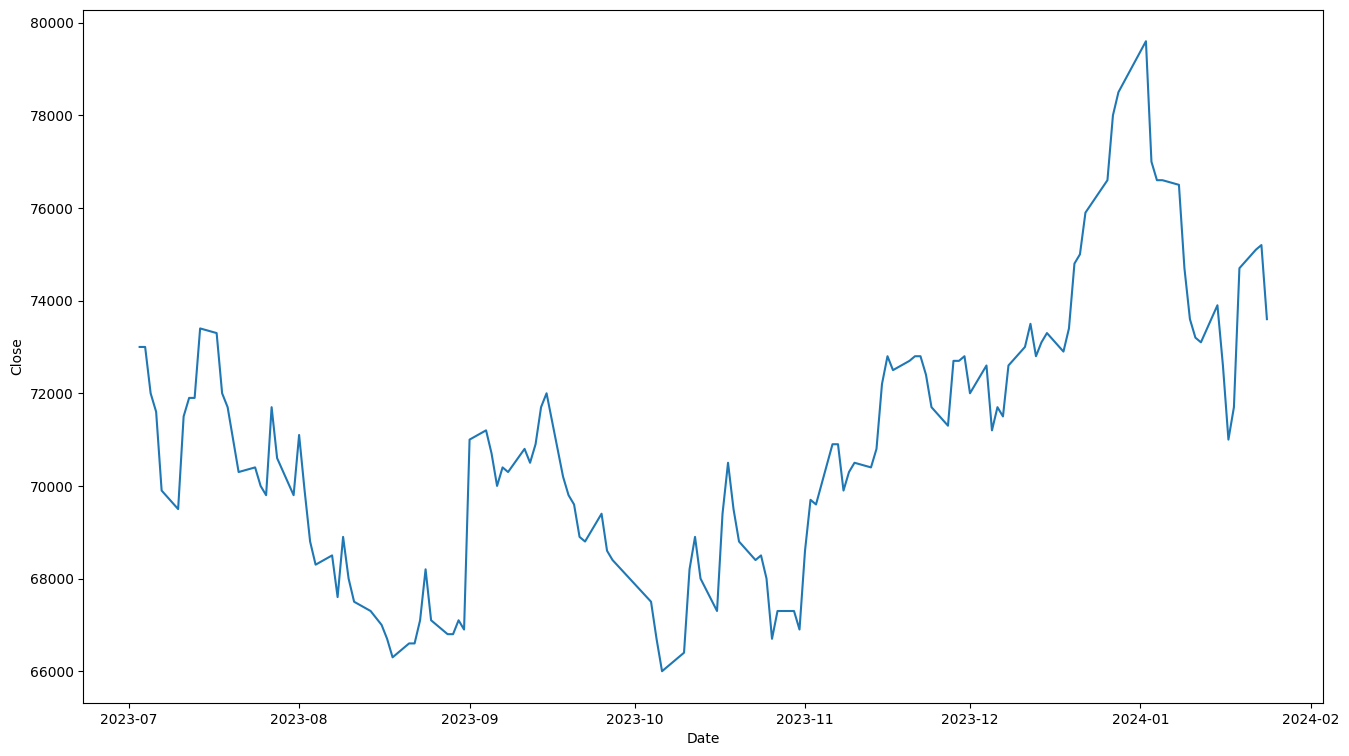

In [6]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df) # 종가 그래프
plt.show()

# 데이터 전처리

In [7]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [8]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [9]:
split = 70
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

<ipython-input-8-650847349e00>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


torch.Size([70, 5, 4]) torch.Size([70, 1])
torch.Size([64, 5, 4]) torch.Size([64, 1])


In [10]:
x_train_seq

tensor([[[0.5360, 0.4962, 0.5484, 0.0944],
         [0.5920, 0.5267, 0.5726, 0.0846],
         [0.5600, 0.5038, 0.4919, 0.1251],
         [0.4720, 0.4351, 0.4597, 0.1726],
         [0.4080, 0.3588, 0.3226, 0.2214]],

        [[0.5920, 0.5267, 0.5726, 0.0846],
         [0.5600, 0.5038, 0.4919, 0.1251],
         [0.4720, 0.4351, 0.4597, 0.1726],
         [0.4080, 0.3588, 0.3226, 0.2214],
         [0.3200, 0.2824, 0.2742, 0.1135]],

        [[0.5600, 0.5038, 0.4919, 0.1251],
         [0.4720, 0.4351, 0.4597, 0.1726],
         [0.4080, 0.3588, 0.3226, 0.2214],
         [0.3200, 0.2824, 0.2742, 0.1135],
         [0.3360, 0.3664, 0.3468, 0.1225]],

        ...,

        [[0.2080, 0.2290, 0.1935, 0.2600],
         [0.1600, 0.1374, 0.1532, 0.0752],
         [0.1520, 0.1374, 0.0806, 0.1306],
         [0.1360, 0.2443, 0.1290, 0.2212],
         [0.2320, 0.2901, 0.2419, 0.2057]],

        [[0.1600, 0.1374, 0.1532, 0.0752],
         [0.1520, 0.1374, 0.0806, 0.1306],
         [0.1360, 0.2443, 0.1290

In [14]:
print(x_train_seq.dim())
print(x_train_seq.size())

3
torch.Size([70, 5, 4])


In [15]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

[링크 텍스트](https:// [링크 텍스트](https://))# Vanila RNN

가장 기초적인 구조의 RNN


## 모델 구축

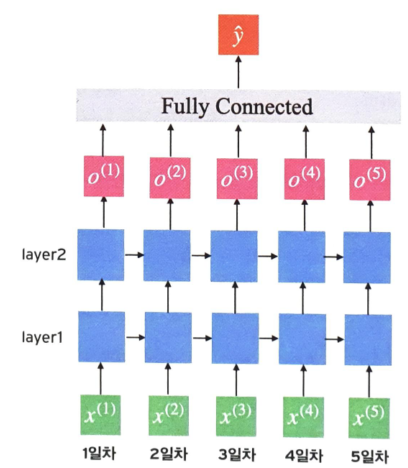

In [16]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [17]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [18]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [19]:
criterion = nn.MSELoss() # MSE Loss 사용
num_epochs = 50 # 50 epoch동안 학습
optimizer = optim.Adam(model.parameters(), lr=1e-3) # learning rate 10^{-3}으로 Adam optimizer 사용

## 모델 학습

In [20]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0428
[epoch : 10] loss: 0.0162
[epoch : 20] loss: 0.0115
[epoch : 30] loss: 0.0108
[epoch : 40] loss: 0.0101


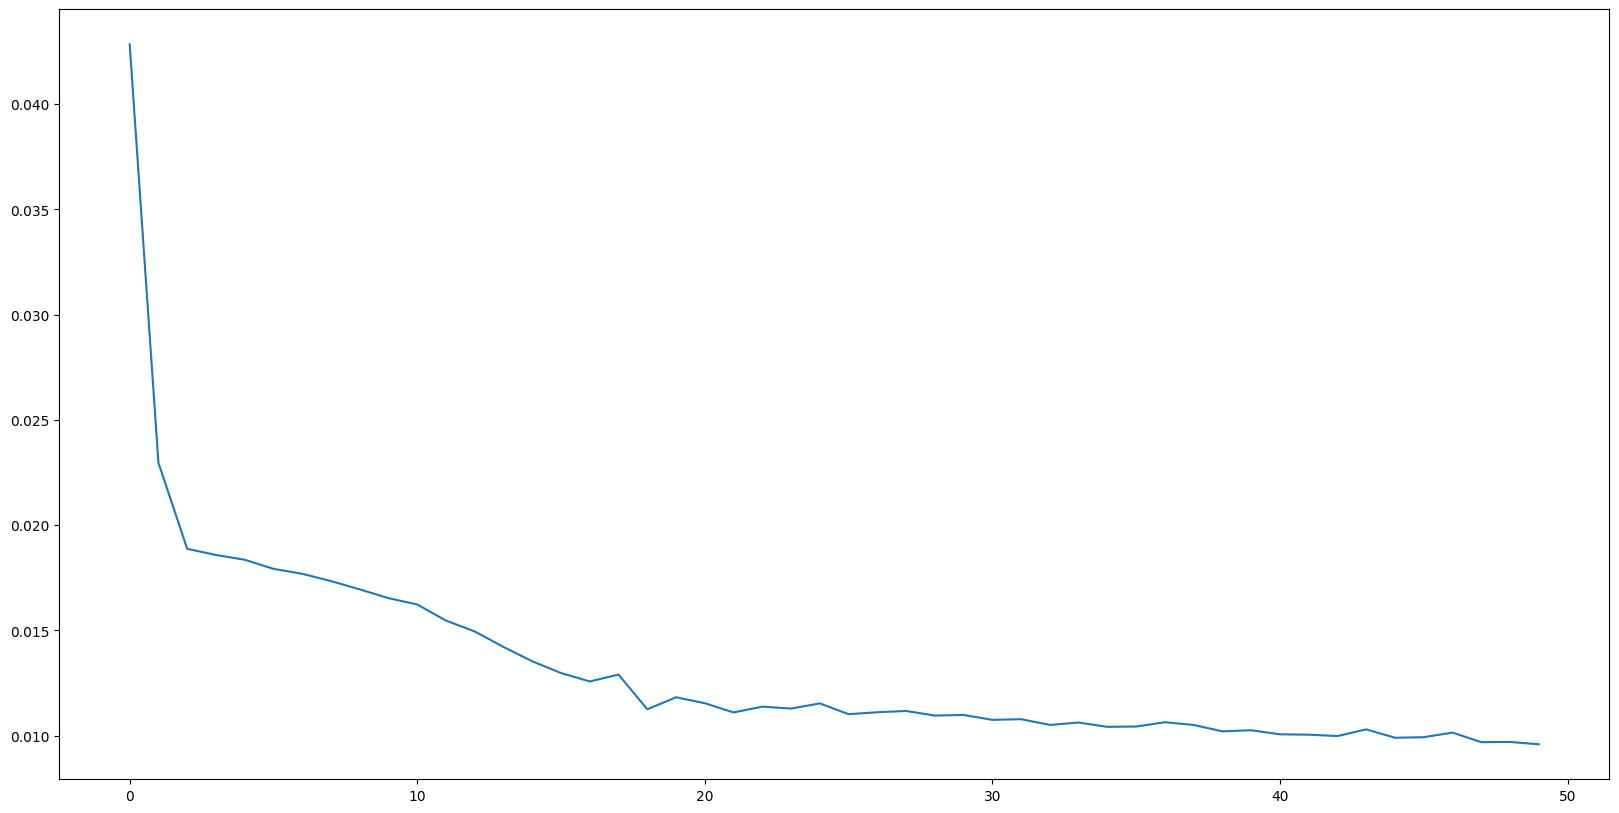

In [22]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph) # loss 가 학습 단계를 거치며 얼마나 감소하는지 그래프로 확인
plt.show()

## 실제값과 예측값 비교

In [31]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred_rnn = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred_rnn += out.cpu().tolist()

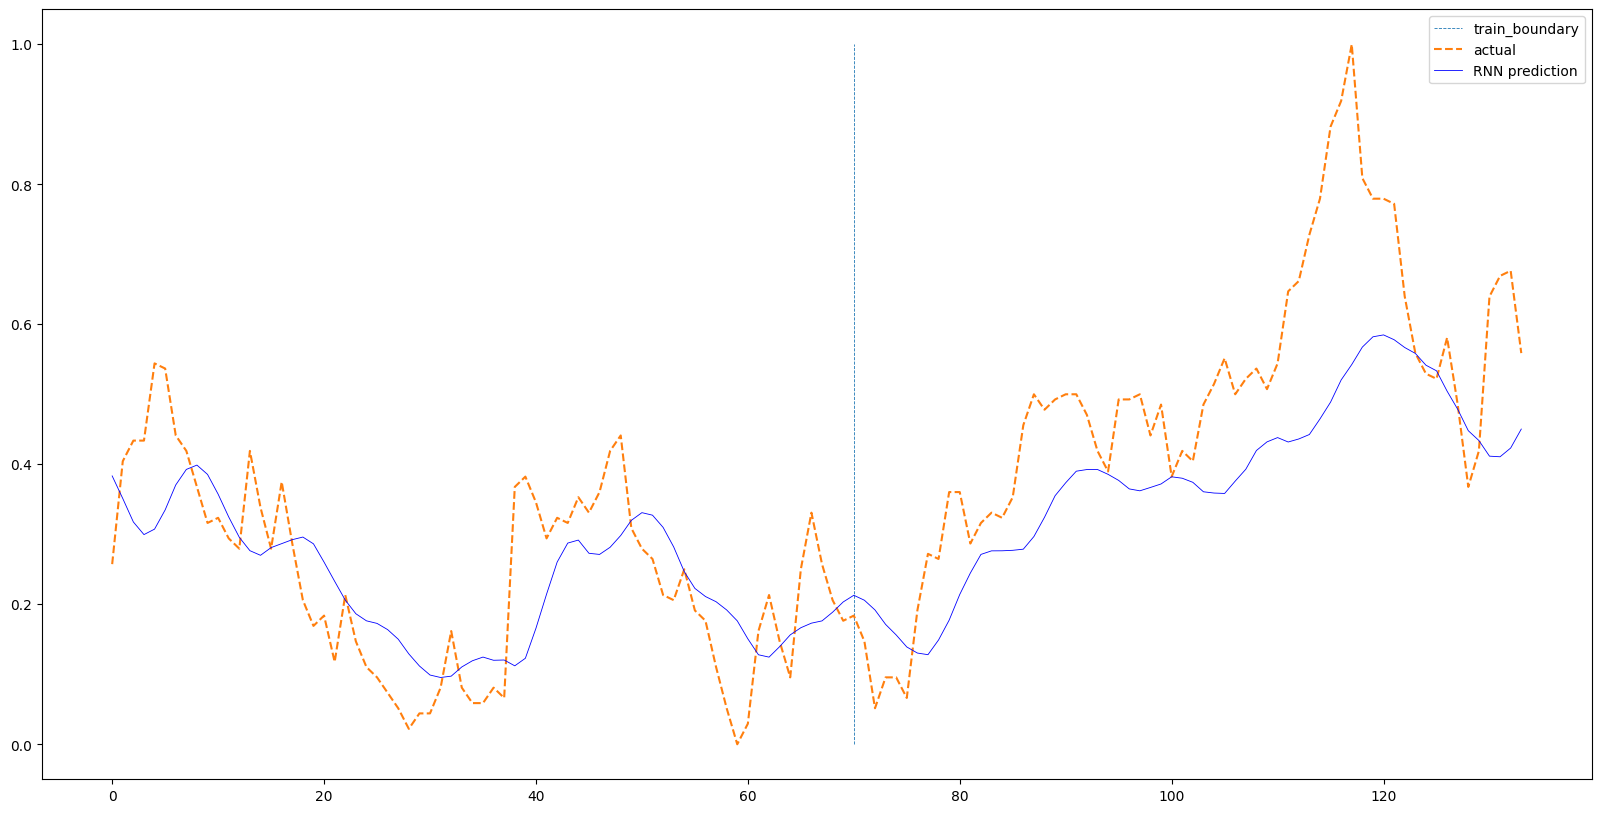

In [32]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred_rnn, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','RNN prediction'])
plt.show()

전반적으로 **prediction 이 actual에 비해 좀 더 smooth하게 예측하는 경향이 있다**

Q) 이것이 noise를 고려하지 않고 예측해서 그런가요?

# LSTM
## 모델구축

In [38]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 5
hidden_size = 10

In [39]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [40]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [41]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [42]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.0474
[epoch: 10] loss: 0.0184
[epoch: 20] loss: 0.0128
[epoch: 30] loss: 0.0110
[epoch: 40] loss: 0.0108


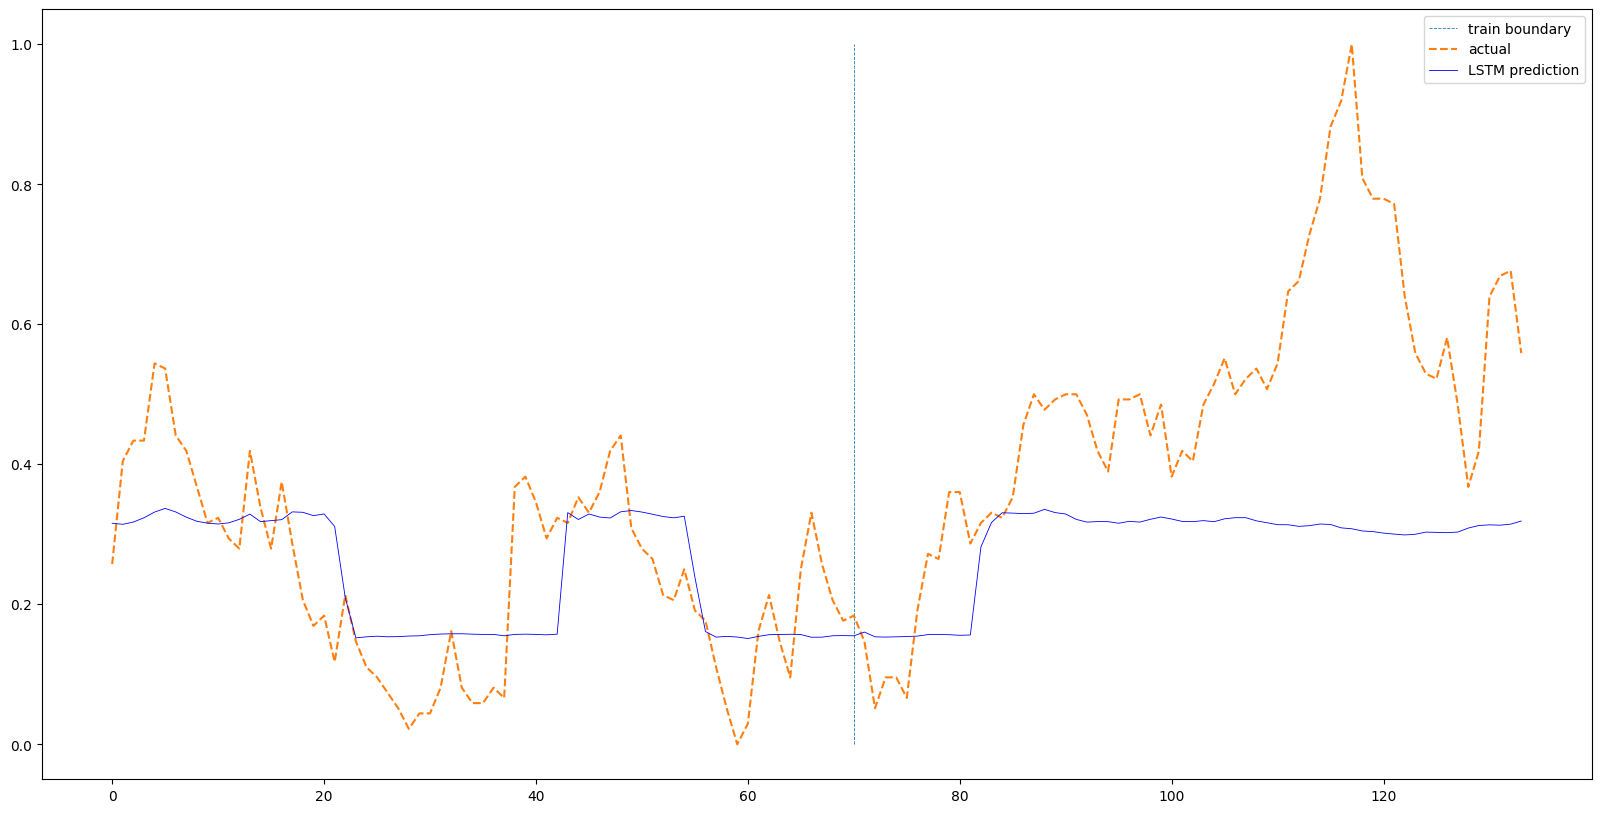

In [43]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred_lstm = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred_lstm += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred_lstm,'b', linewidth=0.6)
plt.legend(['train boundary','actual','LSTM prediction'])
plt.show()

이 두 그래프를 합쳐보았습니다.

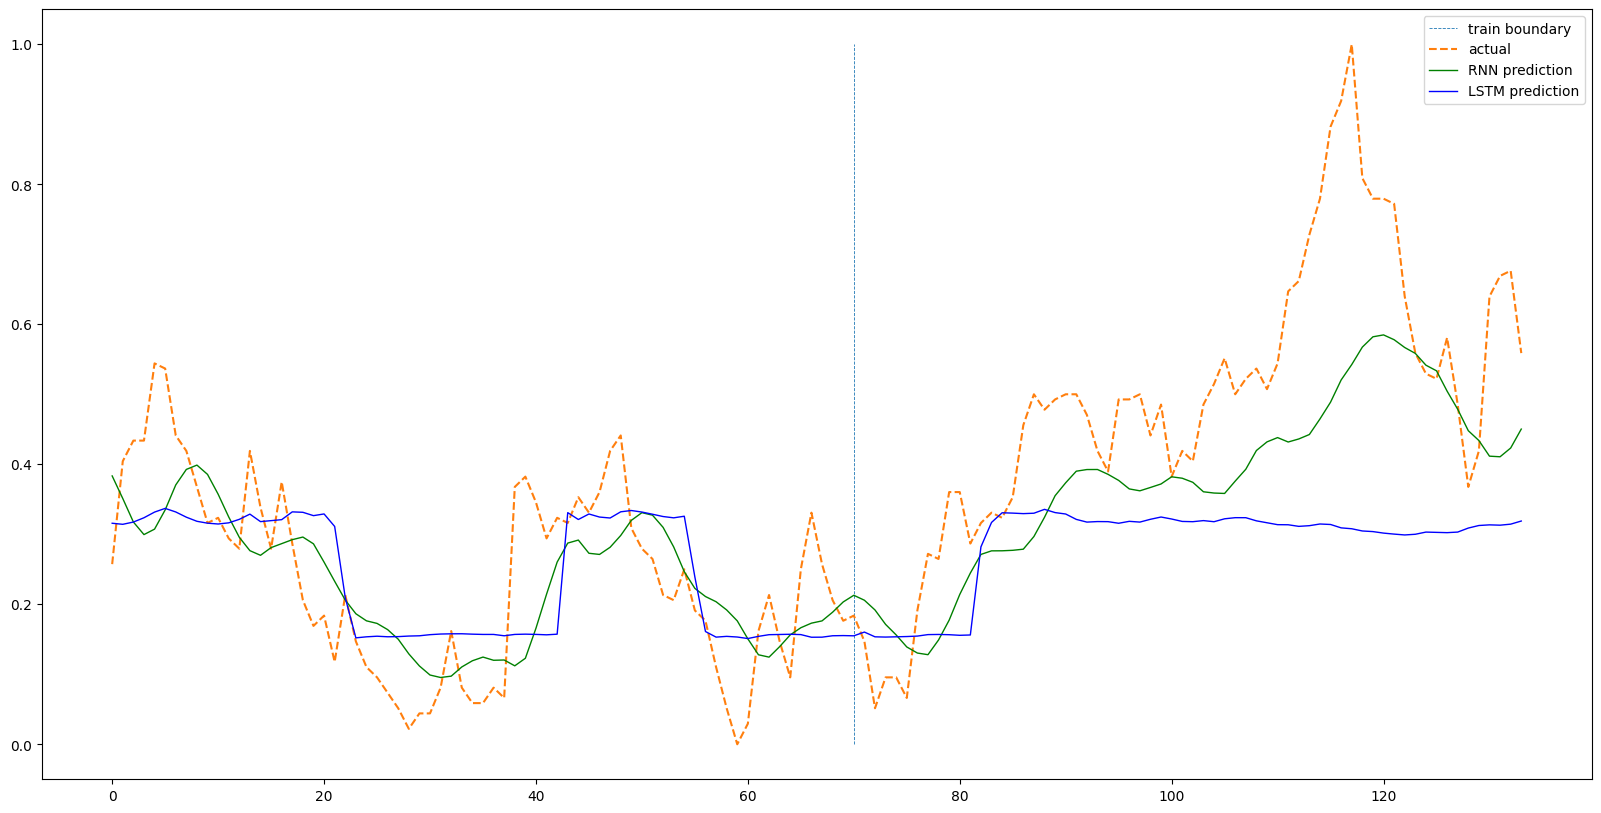

In [44]:
plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred_rnn,'green', linewidth=1)
plt.plot(pred_lstm,'b', linewidth=1)
plt.legend(['train boundary','actual','RNN prediction', 'LSTM prediction'])
plt.show()

LSTM에서 `num_layers = 2`, `hidden_size = 18` 을 했을 때는 둘의 예측이 동일합니다. Forget gate가 작동하지 않는 것 처럼 보였습니다.

그러나 `num_layers = 5`, `hidden_size = 10` 로 임의로 튜닝을 하니 오히려 성능이 떨어졌습니다.